In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
ratings = pd.read_excel('data/generated_average_ratings.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

In [2]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

X['Winter Rain'] =  precipitations.shift(1)['Dec']


X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2

#X['Square Summer Temperature'] = X['Summer Temperature']**2

#X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Winter Temperature'] = \
#    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
#    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
#    (temp_maximals['Fev'] + temp_minimals['Fev'])

#X['Frost Days'] = frost_days['Mar']+ 2*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

##X['Insulation'] = insulation.iloc[:,0]

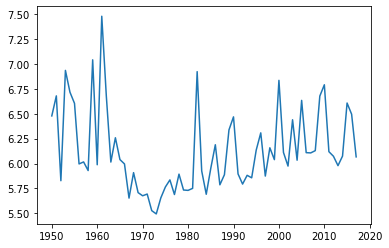

In [3]:
y = prices.set_index('Vintage', drop=True)
sns.lineplot(data=y['Log Price'])
plt.show()

# Developing a metric

The variation of prices will not be easy to predict based on our limited variables. Instead, we choose to classify wines into 4 categories: Good, Very Good, Bad and Very Bad. These categories will be based on the position of the wines compared to the previous decade of production: if a vintage ranks in the top quartile of the window [vintage -horizon -10 years, vintage -horizon years], it will be Very Good, 50-75% quartile will be Good, and so on.

In [4]:
def classifier(prices, key, horizon=3, n_categories=4):
    for vintage in prices.index:
        window = prices.loc[(vintage-horizon-20):(vintage-horizon), 'Log Price']
        window.loc[vintage] = prices.loc[vintage, key]
        prices.loc[vintage, key+' Class'] = pd.qcut(window, n_categories,labels=False, duplicates='drop').iloc[-1]
    prices[key+' Class'] = prices[key+' Class'].fillna(1).astype(int)
    return prices

display(classifier(y, 'Log Price',3).head())

,Price,Log Price,Corrected Log Price,Log Price Class
Vintage,,,,
1950,650.857143,6.478290,-0.051604,1
1951,795.666667,6.679180,0.141060,1
1952,339.714286,5.828105,-0.705901,1
1953,1027.571429,6.934953,0.415460,3
1954,825.714286,6.716249,0.219884,3


# Implementing Kalman Filter

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def Kalman(X,y):
    """Filters observations Y based on weather values X"""
    X = X.reset_index(drop=True)
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
    
    column_names = X.columns.to_list()+['Intercept']
    coefficients = pd.DataFrame(0, index=y.index, columns=column_names)

    x_k = np.array([-0.05, 0, -0.05, 0.35,6]).reshape(-1,1)
    print(np.shape(x_k))
    
    dimension_x = len(X.columns)+1
    
    #initialise the real state's covariant matrix
    P_k = np.eye(dimension_x)*1
    
    # Initialize the covariance matrix of random real state perturbations
    Q = np.eye(dimension_x)*1
    Q[dimension_x-1,dimension_x-1] = 6
    print(Q)
    
    
    # Initialize the covariance matrix of observation noise, here in dimension 1
    R = 14
    predictions = []
    len_buffer = 10
    buffer = [np.zeros_like(x_k)] * len_buffer
    
    min_vintage = y.index[0]
    y['Predicted Log Price']=0

    for vintage in y.index.to_list(): #for each observed value
        
        #Do one step
        H_k = np.array(X.iloc[vintage-min_vintage, :].values.tolist()+[1]).reshape(1,-1)
        
        a, b = 0,10
        coeffs = [0]*len_buffer
        total = sum([a*j+b for j in range(len_buffer-3)])
        for i in range(len_buffer-3):
            coeffs[i] = (a*i + b)/ total
        buffered_x_k = sum([buffer[i]*coeffs[i] for i in range(len_buffer)])
        y.loc[vintage, 'Predicted Log Price'] = (H_k @ buffered_x_k)[0,0]
        
        P_k = P_k + Q
        
        # Computing Kalman gain, i.e. the learning rate
        K = P_k @ H_k.T * (1/(H_k @ P_k @ H_k.T + R))

        # Variable update
        x_k = x_k + (K * (y.loc[vintage, 'Log Price'] - H_k @ x_k))*0.8
        buffer = buffer[1:] + [x_k]
              
        for i in range(len(column_names)):
            coefficients.loc[vintage, column_names[i]]=x_k[i]
        

        P_k = P_k - (K @ H_k @ P_k)
    return y, coefficients
        
y_ex = y.loc[1950:2013][['Log Price']]
X_ex = X.loc[1950:2013,:]
y_result, coefficients = Kalman(X_ex, y_ex)
actual_prices = y_result.loc[1950:2013,'Log Price']
display(y_result['Predicted Log Price'])

print(r2_score(actual_prices[-40:], y_result['Predicted Log Price'][-40:]))

(5, 1)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 6.]]


Vintage
1950    0.000000
1951    0.000000
1952    0.000000
1953    0.000000
1954    0.865722
          ...   
2009    6.304108
2010    6.291882
2011    6.242784
2012    6.374356
2013    5.960467
Name: Predicted Log Price, Length: 64, dtype: float64

0.23173340413390398


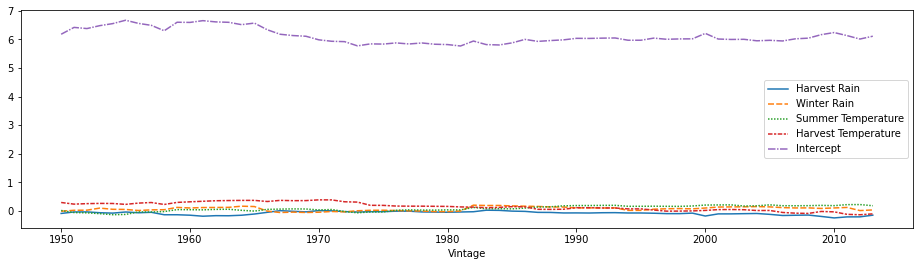

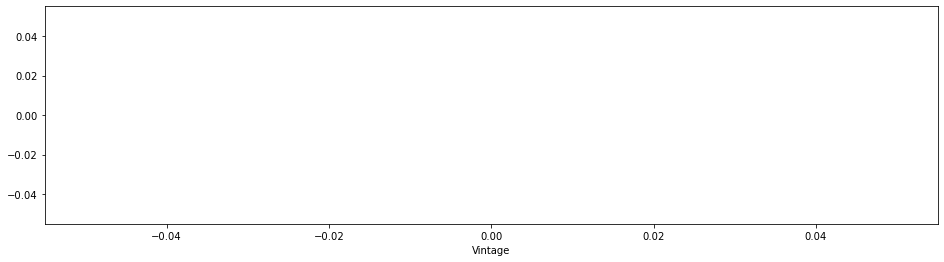

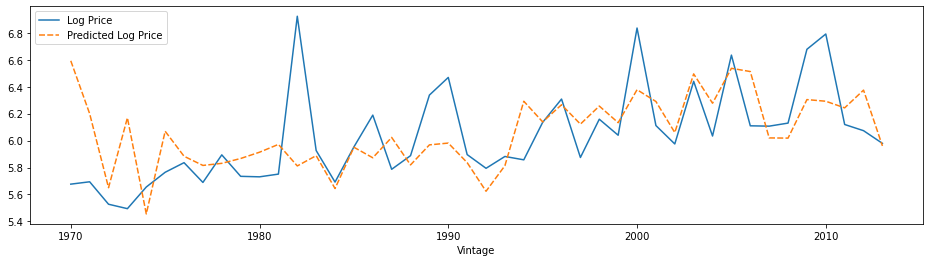

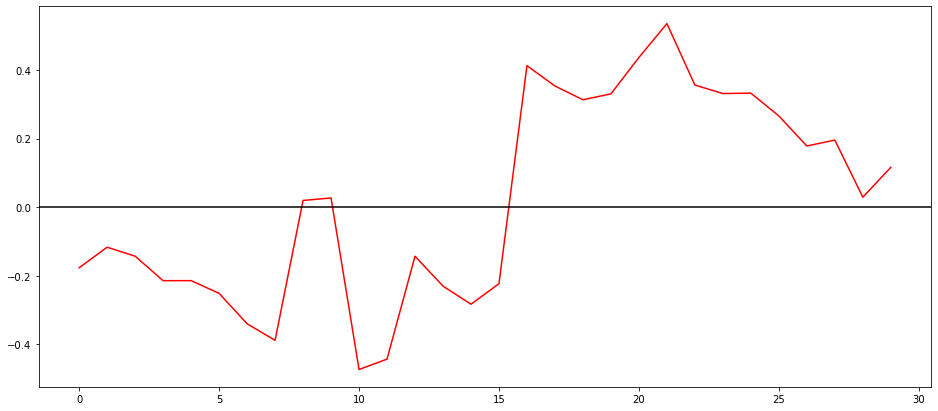

In [6]:
import seaborn as sns

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,:5])
plt.show()


plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,5:])
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=y_result.loc[1970:])
plt.show()

r2_scores=[]
for i in range(55):
    r2_scores.append(r2_score(actual_prices[i:(i+10)],y_result['Predicted Log Price'][i:(i+10)]))
    
plt.figure(figsize=(16,7))
sns.lineplot(x=range(30), y=r2_scores[-30:], color='red').axhline(0., color='black')
plt.show()


We managed to improve over the results of the regression with the Kalman filter, which acts like a decaying memory. Now, classifying the results will give new results. Two options are possible when categorizing the 'Predicted Log Price' column: ranking it amongst the other 'Predicted Log Price' or against the 'Log Price'.
Second options makes accuracy go from 0.29 to 0.47

# Final step: model vs Robert Parker

In [7]:
from sklearn.metrics import accuracy_score

n_categories = 5
y_result = classifier(y_result, 'Predicted Log Price', horizon=3, n_categories=n_categories)
y_result = classifier(y_result, 'Log Price', horizon=3, n_categories=n_categories)
y_rp = y_result.loc[1989:2013,:]
y_rp['Log Price Class 2'] = pd.qcut(y_rp['Log Price'], n_categories, labels=False, duplicates='drop')
y_rp['RP Rating Class 2'] = pd.qcut(ratings.set_index('Vintage')['RP Rating'], n_categories, labels=False, duplicates='drop')
display(y_rp)
print('Accuracy of model predictions: ',accuracy_score(y_rp['Predicted Log Price Class'], y_rp['Log Price Class']).round(2))
print("Accuracy of Robert Parker's ratings: ",accuracy_score(y_rp['RP Rating Class 2'], y_rp['Log Price Class 2']).round(2))
#print('Average error: ', np.mean(np.abs(y_result.loc[1990:2010, 'Predicted Log Price Class'] - y_result.loc[1990:2010, 'Log Price Class'])))

<ipython-input-7-c0eda32aab82>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_rp['Log Price Class 2'] = pd.qcut(y_rp['Log Price'], n_categories, labels=False, duplicates='drop')
<ipython-input-7-c0eda32aab82>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_rp['RP Rating Class 2'] = pd.qcut(ratings.set_index('Vintage')['RP Rating'], n_categories, labels=False, duplicates='drop')


,Log Price,Predicted Log Price,Predicted Log Price Class,Log Price Class,Log Price Class 2,RP Rating Class 2
Vintage,,,,,,
1989,6.337584,5.968160,4,4,3,1
1990,6.468586,5.981406,4,4,4,3
1991,5.896054,5.836432,3,3,0,0
1992,5.794319,5.624073,0,3,0,0
1993,5.882128,5.813741,2,3,0,0
1994,5.857116,6.291814,4,2,0,0
1995,6.135256,6.138764,4,4,3,2
1996,6.308098,6.265971,4,4,3,3
1997,5.874529,6.122113,4,2,0,0


Accuracy of model predictions:  0.56
Accuracy of Robert Parker's ratings:  0.6


We have achieved great precision with only a basic level of tuning! This method of prediction seems to have great potential.

# Appendix: Training a decision tree

[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([3]), array([1]), array([1]), array([1]), array([1]), array([2]), array([2]), array([2]), array([2]), array([3]), array([1]), array([3]), array([2]), array([2]), array([3]), array([3]), array([2]), array([3]), array([3]), array([2]), array([2]), array([3]), array([2]), array([2]), array([2]), array([2]), array([2]), array([3]), array([2]), array([3]), array([2]), array([1]), array([1])]


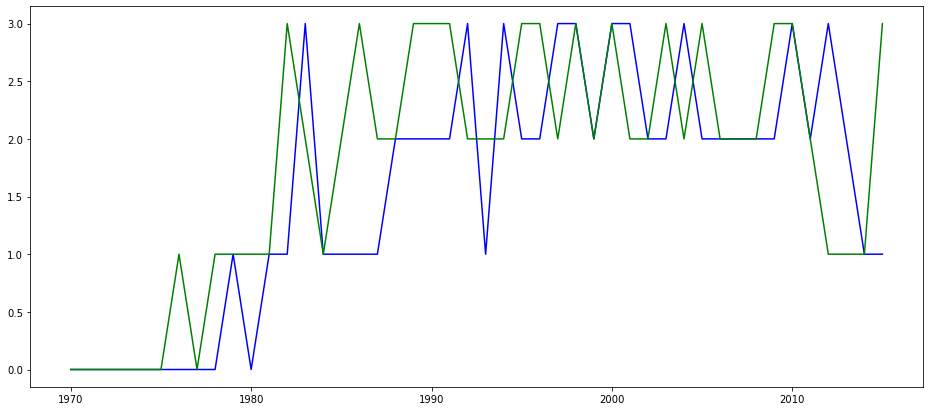

In [8]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
y = classifier(y, 'Log Price', 3)

def model_predict(X,y, window_length, model):
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage-window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price Class'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()

        target = X.loc[target_vintage,:]
        model.fit(X_ex,y_ex)
        
        target = np.array([target_vintage]+target.to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 20
plt.figure(figsize=(16,7))

predictions = model_predict(X,y, window_length, model)
print(predictions)
plt.plot(range(1950+window_length,2016), predictions, color='blue')
sns.lineplot(data=y.loc[1950+window_length:2015,'Log Price Class'], color='green')
plt.show()

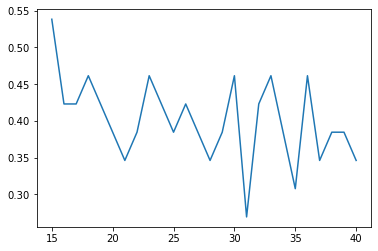

Maximal score:  0.5384615384615384


In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

scores=[]
other_scores=[]

for window_length in range(15,41,1):
    model = DecisionTreeClassifier()
    prediction = model_predict(X,y, window_length, model)
    prediction = prediction[-26:]
    actual_classes = y.loc[1990:2015,'Log Price Class'].values
    scores.append(accuracy_score(actual_classes, prediction))
    
plt.plot(range(15,41,1),scores)
plt.show()
print('Maximal score: ',max(scores))